<a href="https://colab.research.google.com/github/amosdisabatino/KNN-Applicato-Al-Riconoscimento-Di-Frutti-Esotici/blob/main/KNN_applicato_al_riconoscimento_di_frutti_esotici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix,\
  classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Importing the Data

In [2]:
URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'
dataset = pd.read_csv(URL, index_col=None)
dataset.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


The dataset contains few features, making it suitable for application to a KNN model. All the fatures, except the 'Frutto' feature, are of numeric type.

In [3]:
dataset.dtypes

,0
Frutto,object
Peso (g),float64
Diametro medio (mm),float64
Lunghezza media (mm),float64
Durezza buccia (1-10),float64
Dolcezza (1-10),float64


# Preprocessing the Data

It is convenient to standardize the variables before training the model because:

- They have different scales, which can affect the effectiveness of learning algorithms, especially those based on distances (e.g., KNN, SVM, logistic regression, neural networks);

- The mean and standard deviation vary between variables, making some features dominant over others if they are not scaled correctly.

In [4]:
dataset.describe()

,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,47.313440,86.573100,5.298620,7.437640,3.593220
std,26.768797,64.293403,2.641993,1.812548,1.264899
min,8.570000,7.530000,1.150000,3.070000,1.250000
25%,24.797500,50.510000,2.672500,6.152500,2.570000
50%,42.380000,70.450000,5.670000,7.340000,3.535000
75%,68.080000,88.852500,7.455000,8.615000,4.465000
max,111.210000,299.890000,11.140000,13.720000,6.950000


In [5]:
dataset.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


In [6]:
dataset.duplicated().sum()

0

No null and duplicated values are present in the data set.

In [7]:
len(dataset)

500

The dataset contains few instances, which makes it suitable for implementing a KNN model, which works best with a small dataset

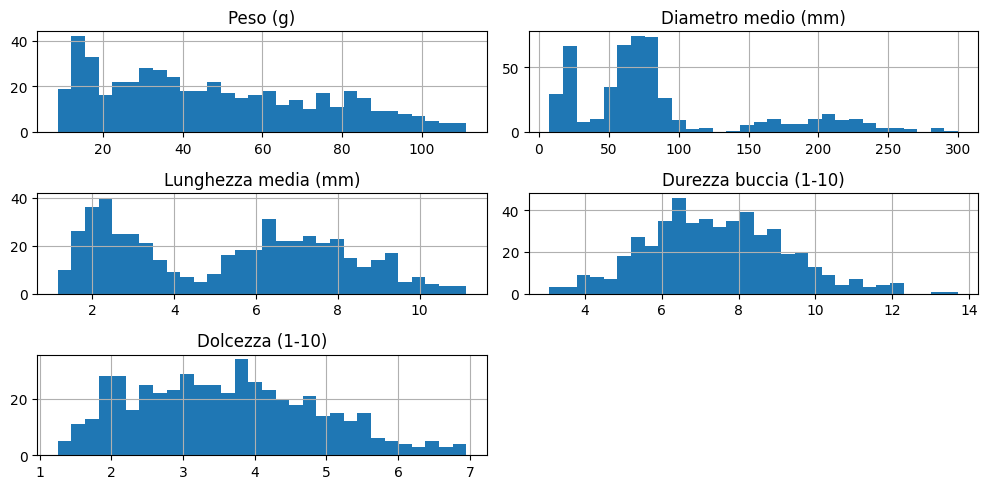

In [8]:
dataset.iloc[:, 1:].hist(bins=30, figsize=(10, 5))
plt.tight_layout()
plt.show()

Only the variables 'Durezza Buccia' and 'Dolcezza' tend to follow a normal distribution.
The 'Lunghezza Media' feature tend to follow a bimodal distribution.


In [9]:
dataset['Frutto'].value_counts()

,count
Frutto,
Mela,100
Banana,100
Arancia,100
Uva,100
Kiwi,100


The 'Frutto' feature is well balanced with respect to the different values it can take.

In [10]:
fruits_mapping = {
    'Mela': 1,
    'Banana': 2,
    'Arancia': 3,
    'Uva': 4,
    'Kiwi': 5,
}
dataset['Frutto'] = dataset['Frutto'].map(fruits_mapping)

To use the 'Frutto' feature in the model, it is necessary to transform the variable to numeric.

# Correlation Analysis

To select the features to be applied to the KNN model, I decide to analyze the correlation of the features by applying the 'Pearson' and 'Spearman' correlation coefficients.

In [11]:
pearson_matrix = dataset.corr(method='pearson')

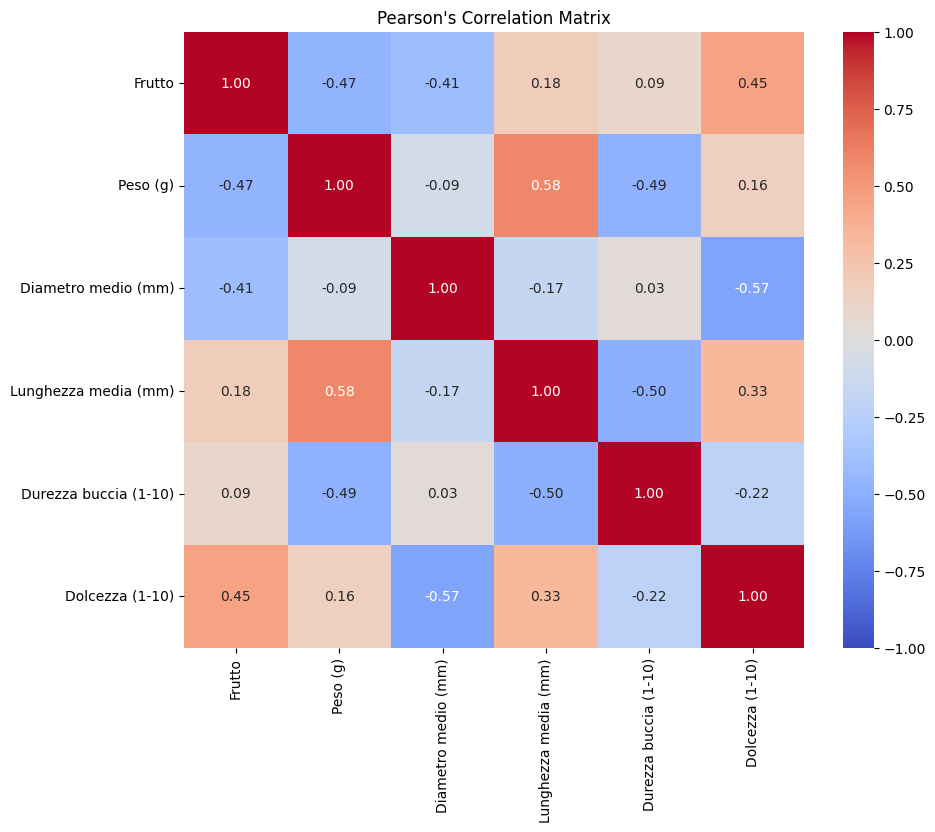

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Pearson's Correlation Matrix")
plt.show()

In [13]:
spearman_matrix = dataset.corr(method='spearman')

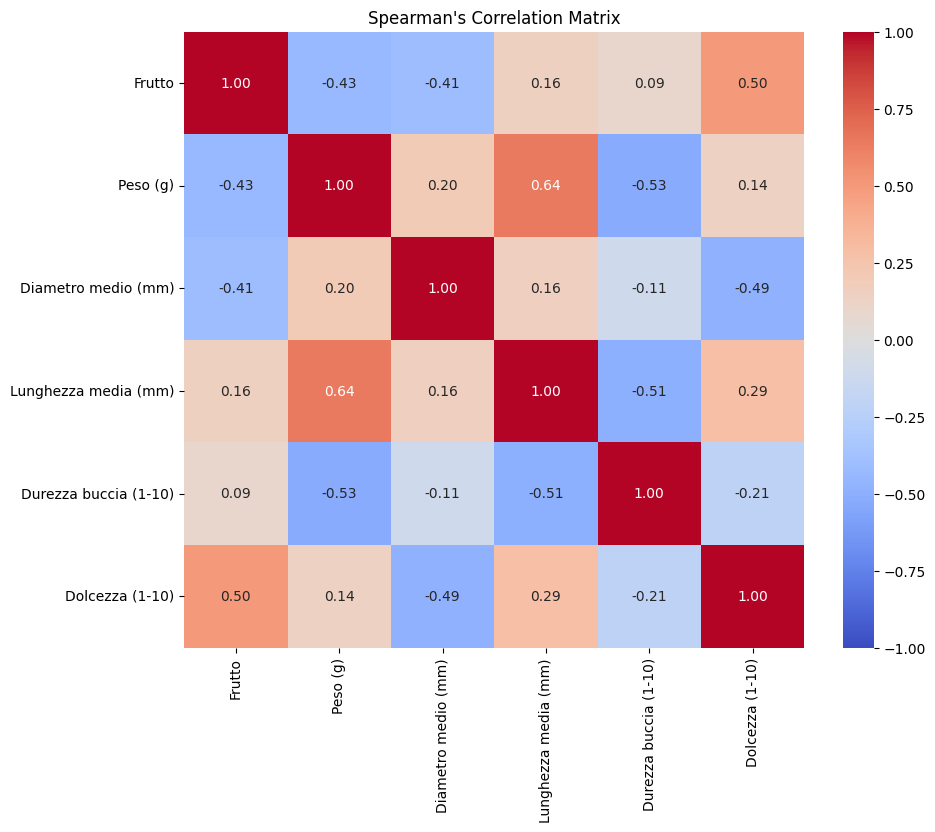

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Spearman's Correlation Matrix")
plt.show()

With both methods, the features most correlated with the target feture 'Frutto' appear to be: 'Peso (g)' and 'Diametro medio (mm)', which have a good negative correlation, and 'Dolcezza (1-10)', which has a good positive correlation.

In [15]:
str_fruits_mapping = {
    1: 'Mela',
    2: 'Banana',
    3: 'Arancia',
    4: 'Uva',
    5: 'Kiwi'
}

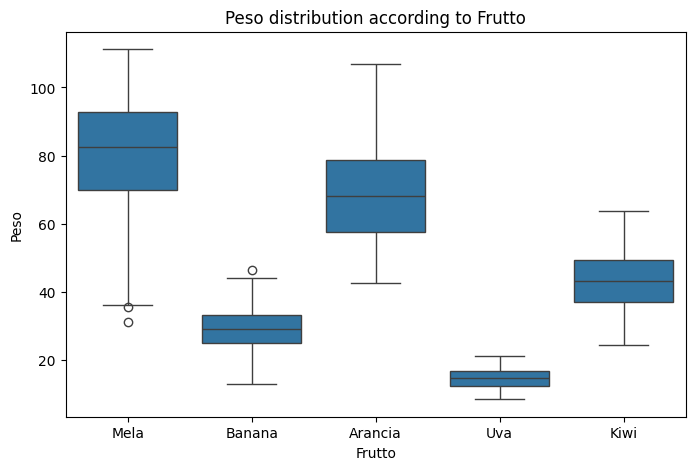

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=dataset['Frutto'].map(str_fruits_mapping),
    y=dataset['Peso (g)'],
)
plt.title("Peso distribution according to Frutto")
plt.xlabel("Frutto")
plt.ylabel("Peso")
plt.show()

In this boxplot, it is possible to see that for each type of fruit, gets different boxes (and thus ranges), which makes the variable a good one for distinguishing fruit types.

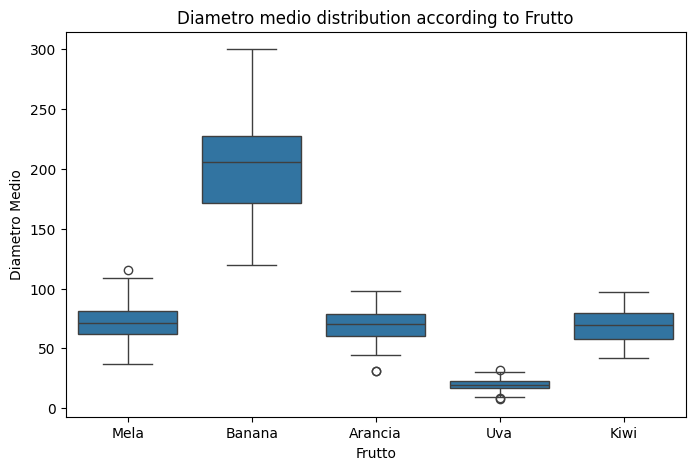

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=dataset['Frutto'].map(str_fruits_mapping),
    y=dataset['Diametro medio (mm)'],
)
plt.title("Diametro medio distribution according to Frutto")
plt.xlabel("Frutto")
plt.ylabel("Diametro Medio")
plt.show()

The variable 'Diametro medio (mm)' succeeds in categorizing 'Banana' and 'Grape' fruits well, while the others have a pratically equal average diameter.

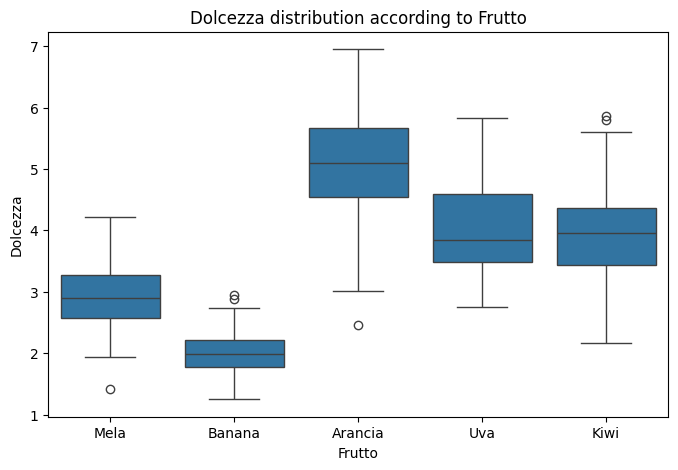

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=dataset['Frutto'].map(str_fruits_mapping),
    y=dataset['Dolcezza (1-10)'],
)
plt.title("Dolcezza distribution according to Frutto")
plt.xlabel("Frutto")
plt.ylabel("Dolcezza")
plt.show()

Also in this graph you can see that the variable "Dolcezza" seems to distinguish well between different fruits, which have boxes with different ranges.

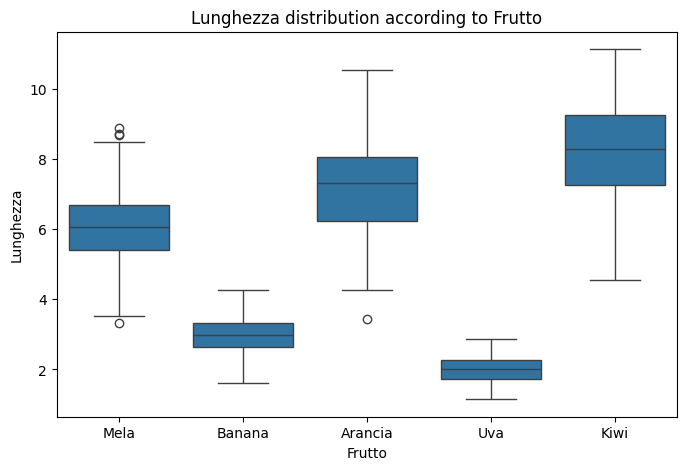

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=dataset['Frutto'].map(str_fruits_mapping),
    y=dataset['Lunghezza media (mm)'],
)
plt.title("Lunghezza distribution according to Frutto")
plt.xlabel("Frutto")
plt.ylabel("Lunghezza")
plt.show()

The "Lunghezza" variable, although poorly correlated with the "Frutto" variable, seems to differentiate the various fruits well.

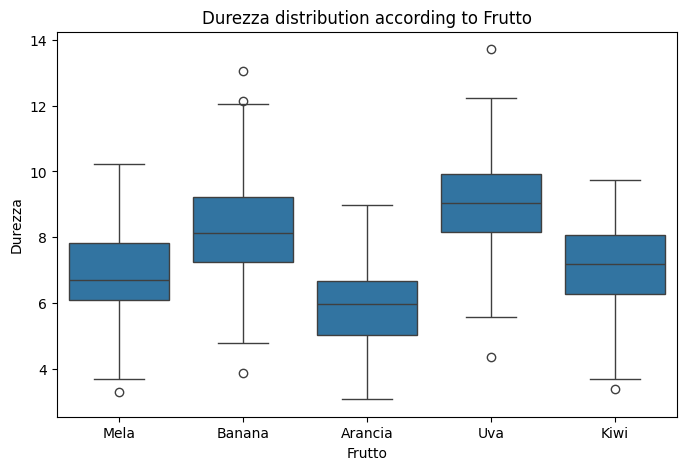

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=dataset['Frutto'].map(str_fruits_mapping),
    y=dataset['Durezza buccia (1-10)'],
)
plt.title("Durezza distribution according to Frutto")
plt.xlabel("Frutto")
plt.ylabel("Durezza")
plt.show()

The same cannot be said for the "Durezza" variable; the boxes are quite similar.

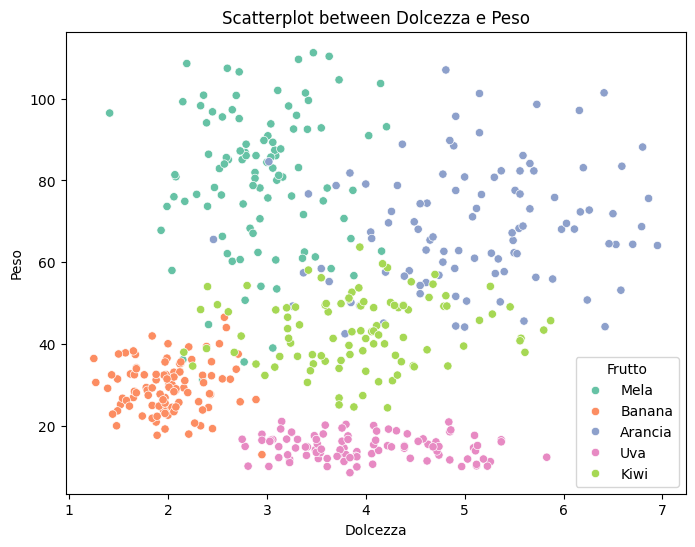

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=dataset['Dolcezza (1-10)'], y=dataset['Peso (g)'],
    hue=dataset['Frutto'].map(str_fruits_mapping), palette="Set2"
)
plt.title(f'Scatterplot between Dolcezza e Peso')
plt.xlabel('Dolcezza')
plt.ylabel('Peso')
plt.show()

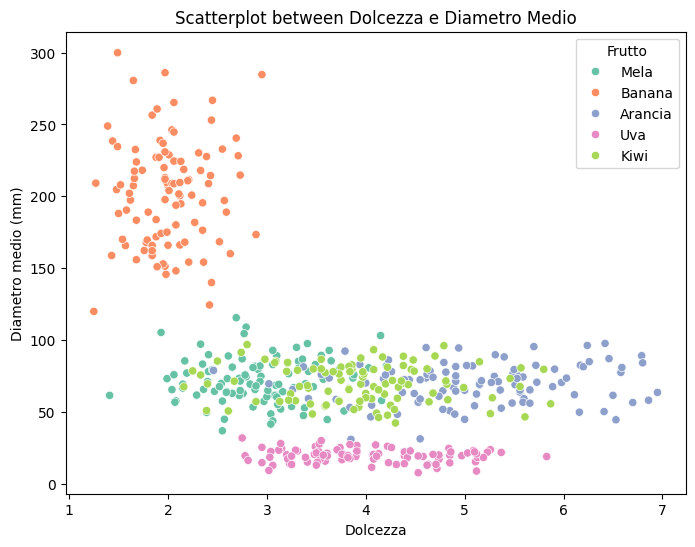

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=dataset['Dolcezza (1-10)'], y=dataset['Diametro medio (mm)'],
    hue=dataset['Frutto'].map(str_fruits_mapping), palette="Set2"
)
plt.title(f'Scatterplot between Dolcezza e Diametro Medio')
plt.xlabel('Dolcezza')
plt.ylabel('Diametro medio (mm)')
plt.show()

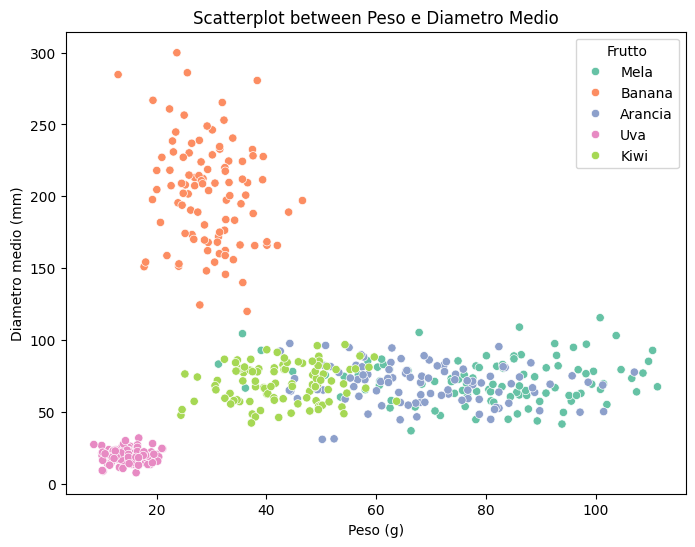

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=dataset['Peso (g)'], y=dataset['Diametro medio (mm)'],
    hue=dataset['Frutto'].map(str_fruits_mapping), palette="Set2"
)
plt.title(f'Scatterplot between Peso e Diametro Medio')
plt.xlabel('Peso (g)')
plt.ylabel('Diametro medio (mm)')
plt.show()

In all three scatter plots, where the three most highly correlated variables are related, it can be seen that there are two clearly distinct clusters for the "Banana" and "Uva" type fruits, while the "Mela", "Arancia" and “Kiwi” type fruits, with the exception of the first scatter plot, have fairly similar characteristics.

# Implementing KNN Model

In [24]:
fields = ['Peso (g)','Diametro medio (mm)', 'Dolcezza (1-10)']
X = dataset[fields]
y = dataset['Frutto']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

To implement the KNN algorithm, I decide to apply standardization of the variables, so that they have the same scale of values and to use GridSearchCV, so as to train the models through "Cross Validation" (also because there are few instances) and find the best "hyper parameters" to apply to the model.
I decided to use PCA to get only two variables to use to later implement graphs to display the results.

In [25]:
scaler = StandardScaler()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

knn = GridSearchCV(
    KNeighborsClassifier(),
     {
         'n_neighbors': np.arange(2, 21, 1),
         'weights': ['uniform', 'distance'],
    },
    scoring='accuracy', cv=5,
)
knn.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

The optimal number of neighbors to make predictions about new instances seems to be 10.

## Performance Analysis

### Accuracy

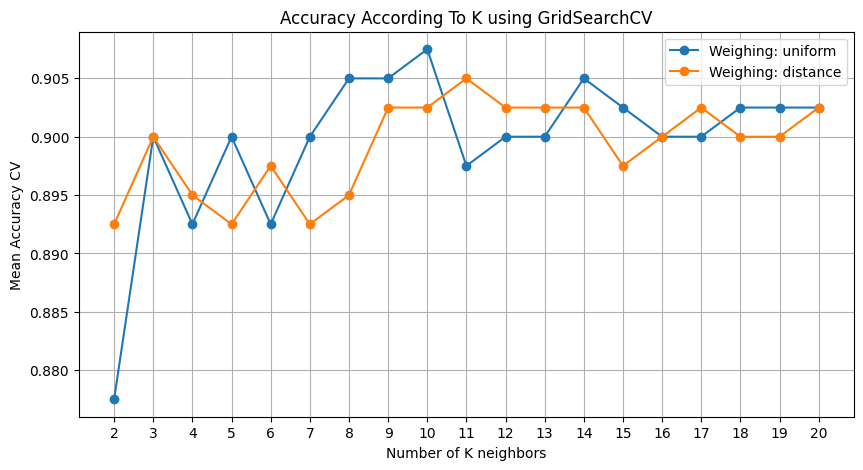

In [26]:
results = pd.DataFrame(knn.cv_results_)

plt.figure(figsize=(10, 5))

for weight in ['uniform', 'distance']:
    subset = results[results['param_weights'] == weight]
    plt.plot(
        subset['param_n_neighbors'],
        subset['mean_test_score'],
        marker='o',
        label=f'Weighing: {weight}'
    )

plt.xlabel("Number of K neighbors")
plt.ylabel("Mean Accuracy CV")
plt.title("Accuracy According To K using GridSearchCV")
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid(True)
plt.show()

### Classification Error

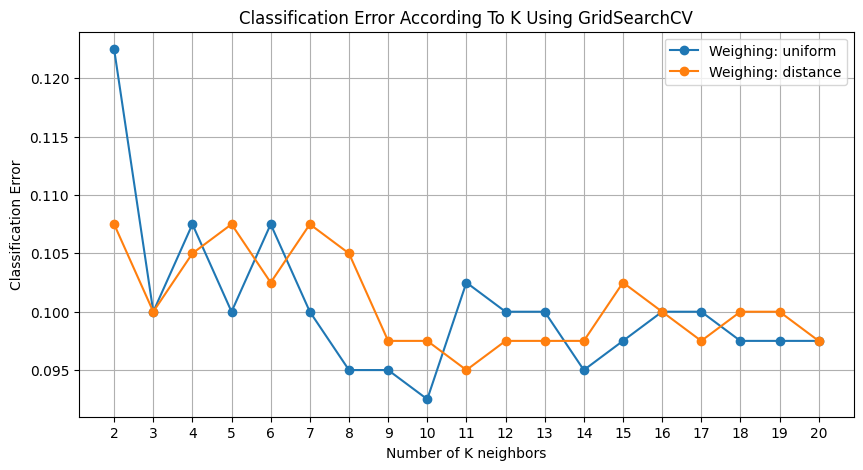

In [27]:
results['classification_error'] = 1 - results['mean_test_score']


plt.figure(figsize=(10, 5))


for weight in ['uniform', 'distance']:
    subset = results[results['param_weights'] == weight]
    plt.plot(
        subset['param_n_neighbors'],
        subset['classification_error'],
        marker='o',
        label=f'Weighing: {weight}'
    )

plt.xlabel("Number of K neighbors")
plt.ylabel("Classification Error")
plt.title("Classification Error According To K Using GridSearchCV")
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid(True)
plt.show()

The graphs seem to confirm that 10 is the perfect number for making new predictions on instances, in fact, with such a hyper parameter, an accuracy of more than 0.9 and a classification error of less than 0.095 is achieved.

## Using the Model

In [28]:
y_pred_train = knn.predict(X_train_pca)

In [29]:
print(
    classification_report(
        y_train, y_pred_train, target_names=str_fruits_mapping.values()
    )
)

              precision    recall  f1-score   support

        Mela       0.89      0.89      0.89        80
      Banana       1.00      1.00      1.00        80
     Arancia       0.86      0.82      0.84        80
         Uva       0.99      1.00      0.99        80
        Kiwi       0.82      0.84      0.83        80

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [30]:
accuracy_score(y_train, y_pred_train)

0.91

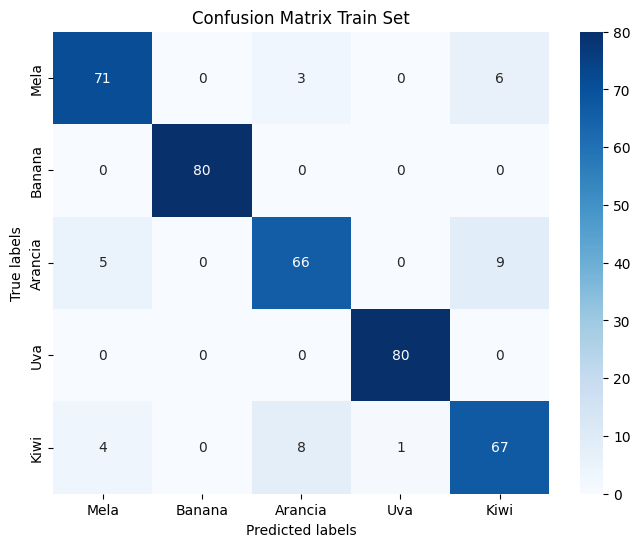

In [31]:
cm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, cmap='Blues', fmt='d',
    xticklabels=str_fruits_mapping.values(),
    yticklabels=str_fruits_mapping.values(),
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train Set')
plt.show()

During the training phase, the model manages to achieve an accuracy of 0.91, and for each type of fruit, excellent values of "Precision", "Recall" and "F1-Score" are obtained.
The lowest values are given by the "Arancia" and "Kiwi" fruits, which still obtain "F1-Score" of "0.84" and "0.83" respectively.

In [32]:
knn.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

Through the use of `best_params_` we can see that a "uniform" weighting is applied to all neighbors.

In [33]:
y_pred_test = knn.predict(X_test_pca)

In [34]:
print(
    classification_report(
        y_test, y_pred_test,
        target_names=str_fruits_mapping.values()
    )
)

              precision    recall  f1-score   support

        Mela       0.94      0.80      0.86        20
      Banana       1.00      1.00      1.00        20
     Arancia       0.82      0.70      0.76        20
         Uva       1.00      1.00      1.00        20
        Kiwi       0.69      0.90      0.78        20

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



In [35]:
accuracy_score(y_test, y_pred_test)

0.88

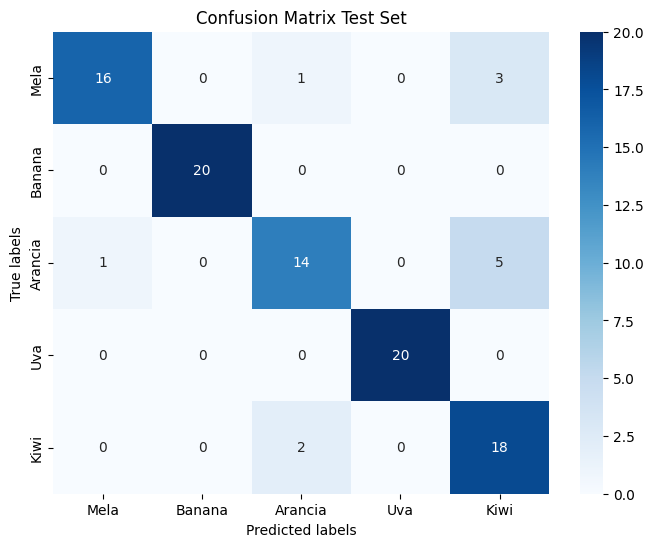

In [36]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, cmap='Blues', fmt='d',
    xticklabels=str_fruits_mapping.values(),
    yticklabels=str_fruits_mapping.values(),
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Set')
plt.show()

During the testing phase, the model manages to achieve an accuracy of 0.88, and good values of "Precision", "Recall" and "F1-Score" are obtained for each type of fruit. Even at this stage, the lowest values are recorded for "Arancia" and "Kiwi" fruits, which still achieve "F1-Score" of "0.76" and "0.78" respectively, which are still acceptable during the testing phase.

## Display the results

### Trainig Set

In [37]:
df_pca_training = pd.DataFrame(
    X_train_pca,
    columns=['PCA1', 'PCA2'],
)
df_pca_training['Frutto'] = y_train.values


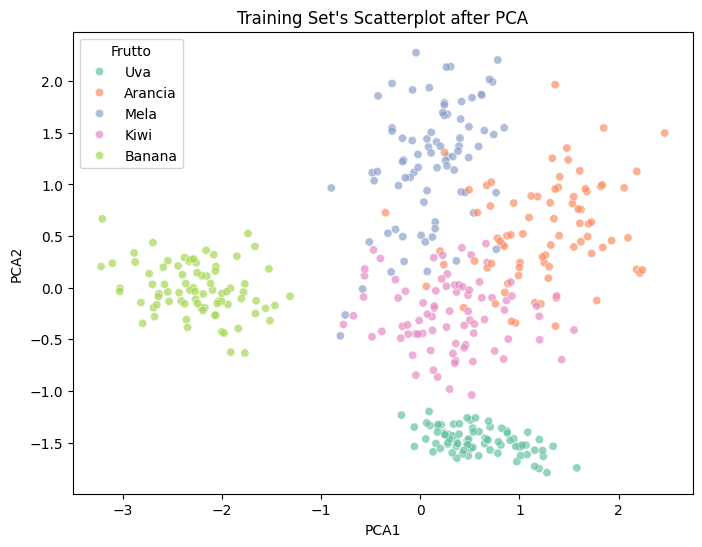

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_pca_training['PCA1'],
    y=df_pca_training['PCA2'],
    hue=df_pca_training['Frutto'].map(str_fruits_mapping),
    palette='Set2',
    alpha=0.7
)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Training Set's Scatterplot after PCA")
plt.legend(title='Frutto')
plt.show()

The scatterplot of the training data with the two principal components seems to confirm that the data for "Banana" and "Uva" fruits are well differentiated from the others, which suggests that the model may have some difficulty in predicting type fruits:"Mela", "Arnacia" e "Kiwi".

In [39]:
x = df_pca_training.iloc[110, :-1]
y_pred = knn.predict([x])
y_pred[0]
print(y_pred[0], str_fruits_mapping[y_pred[0]])

3 Arancia


In [40]:
print(
    df_pca_training.iloc[110, -1],
    str_fruits_mapping[df_pca_training.iloc[110, -1]]
)

3 Arancia


The value predicted by the model and the actual value combine.

In [41]:
distances, neighbors = knn.best_estimator_.kneighbors([x])

In [42]:
distances

array([[0.        , 0.03735673, 0.04857953, 0.36156897, 0.42483363,
        0.44902786, 0.5103217 , 0.52224575, 0.63370546, 0.66772024]])

In [43]:
neighbors

array([[110, 374,  14, 109, 329, 283, 302,  26,   1, 153]])

In [44]:
X_neighbors = X_train_pca[neighbors][0]

In [45]:
X_neighbors

array([[ 2.214456  ,  0.14296125],
       [ 2.23866569,  0.17141148],
       [ 2.18004561,  0.17725258],
       [ 2.09386695,  0.48382838],
       [ 1.92772883,  0.45644354],
       [ 1.8393444 ,  0.38977557],
       [ 1.77948565, -0.12392645],
       [ 1.72743607,  0.3315142 ],
       [ 1.68757316,  0.49506505],
       [ 1.61921859,  0.44552158]])

In [46]:
X_neighbors.shape

(10, 2)

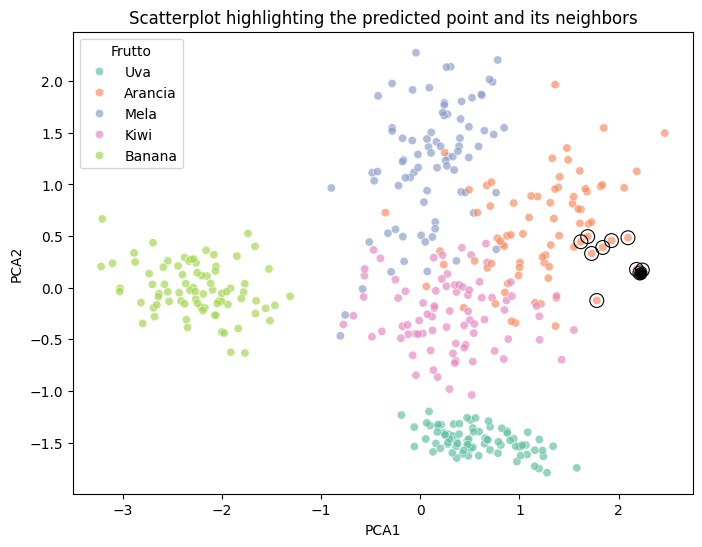

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_pca_training['PCA1'],
    y=df_pca_training['PCA2'],
    hue=df_pca_training['Frutto'].map(str_fruits_mapping),
    palette='Set2',
    alpha=0.7
)

sns.scatterplot(
    x=[x['PCA1']],
    y=[x['PCA2']],
    color="black",
    marker="o",
    s=100,
    legend=False,
)


sns.scatterplot(
    x=X_neighbors[:, 0],
    y=X_neighbors[:, 1],
    color="none",
    edgecolor="black",
    marker="o",
    s=100,
    legend=False
)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Scatterplot highlighting the predicted point and its neighbors")
plt.legend(title='Frutto')
plt.show()

I tried to show in this last scatter how a point is classified by highlighting it and its neighbors, the fruit is correctly classified as "Arancia".

### Test Set

In [48]:
df_pca_test = pd.DataFrame(
    X_test_pca,
    columns=['PCA1', 'PCA2'],
)
df_pca_test['Frutto'] = y_test.values

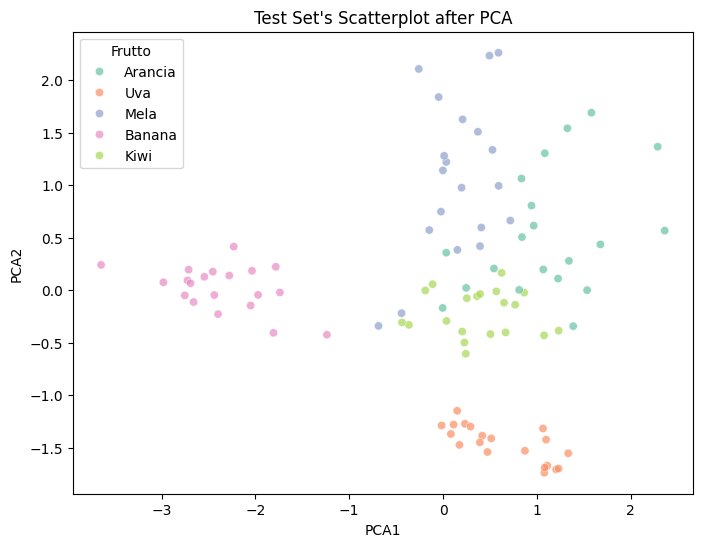

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_pca_test['PCA1'],
    y=df_pca_test['PCA2'],
    hue=df_pca_test['Frutto'].map(str_fruits_mapping),
    palette='Set2',
    alpha=0.7
)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Test Set's Scatterplot after PCA")
plt.legend(title='Frutto')
plt.show()

Even in the scatterplot of the test data, greater differentiation can be seen for "Banana" and "Uva" type fruits than for the others.

In [50]:
x = df_pca_test.iloc[10, :-1]
y_pred = knn.predict([x])
y_pred[0]
print(y_pred[0], str_fruits_mapping[y_pred[0]])

5 Kiwi


In [51]:
print(
    df_pca_test.iloc[10, -1],
    str_fruits_mapping[df_pca_test.iloc[10, -1]]
)

5 Kiwi


The value predicted by the model and the actual value combine.

In [52]:
distances, neighbors = knn.best_estimator_.kneighbors([x])

In [53]:
distances

array([[0.09485105, 0.18873858, 0.19031082, 0.23072637, 0.23724469,
        0.27020075, 0.2707563 , 0.31515369, 0.31840459, 0.33667262]])

In [54]:
neighbors

array([[349,  45, 326, 333, 359, 387, 248, 181, 175, 136]])

In [55]:
X_neighbors = X_train_pca[neighbors][0]

In [56]:
X_neighbors

array([[-0.3876798 , -0.42254026],
       [-0.17976575, -0.37284432],
       [-0.48744062, -0.47539204],
       [-0.1959006 , -0.48906233],
       [-0.12836703, -0.36040494],
       [-0.22317721, -0.10000339],
       [-0.12099588, -0.45066727],
       [-0.67339554, -0.2720827 ],
       [-0.57157708, -0.08953054],
       [-0.04753212, -0.44631429]])

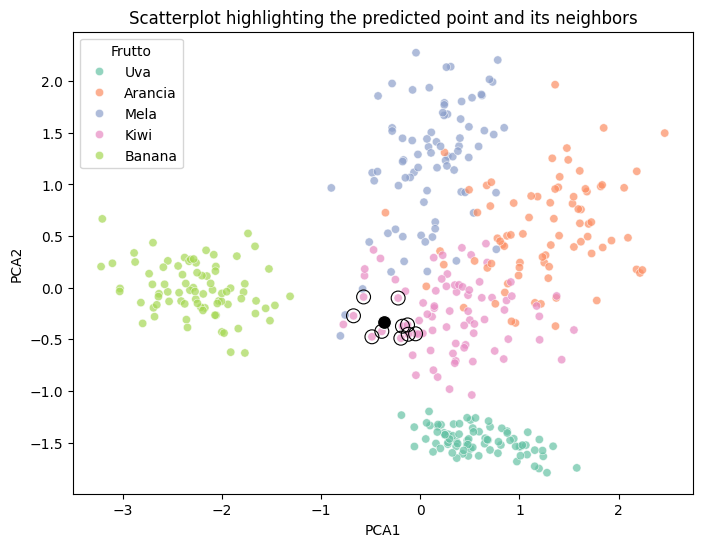

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_pca_training['PCA1'],
    y=df_pca_training['PCA2'],
    hue=df_pca_training['Frutto'].map(str_fruits_mapping),
    palette='Set2',
    alpha=0.7
)

sns.scatterplot(
    x=[x['PCA1']],
    y=[x['PCA2']],
    color="black",
    marker="o",
    s=100,
    legend=False,
)


sns.scatterplot(
    x=X_neighbors[:, 0],
    y=X_neighbors[:, 1],
    color="none",
    edgecolor="black",
    marker="o",
    s=100,
    legend=False
)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Scatterplot highlighting the predicted point and its neighbors")
plt.legend(title='Frutto')
plt.show()

In this scatter, I have tried to show how the classification of a new point (in the test set) with respect to its neighbors in the training set takes place, both in the graph and in the preceding lines of code you can see how it has been correctly predicted as a Kiwi.